## Вспомогательные функции

In [14]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'

Импортирование необходимых библиотек.

In [15]:
import gzip
import shutil
import urllib

from matplotlib import pyplot as plt
from tqdm.notebook import trange
from typing import Sequence, List

import cv2
import imageio
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

from IPython.display import Image, display

Вспомогательные функции для скачивания набора данных MNIST.

In [16]:
DATA_ROOT = './data'
MNIST_FILES = {
    'mnist_data_train': 'http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'mnist_data_test': 'http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
}

def _download(url, filename):
    if not os.path.exists(DATA_ROOT):
        os.makedirs(DATA_ROOT)

    out_file = os.path.join(DATA_ROOT, f'{filename}.gz')
    if not os.path.isfile(out_file):
        urllib.request.urlretrieve(url, out_file)
        print(f'Downloaded {url} to {out_file}')
    else:
        print(f'{out_file} already downloaded')

def _unpack_and_save_to_npy(filename):
    gzip_file = os.path.join(DATA_ROOT, f'{filename}.gz')
    npy_file = os.path.join(DATA_ROOT, f'{filename}.npy')

    if os.path.isfile(npy_file):
        print(f'{npy_file} already exists')
        return

    with gzip.open(gzip_file, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28, 28)

    np.save(npy_file, data)
    print(f'Unpacked {gzip_file} to {npy_file}')

def _fetch_data(files):
    for filename, url in files.items():
        _download(url, filename)
        _unpack_and_save_to_npy(filename)

In [17]:
_fetch_data(MNIST_FILES)

./data/mnist_data_train.gz already downloaded
./data/mnist_data_train.npy already exists
./data/mnist_data_test.gz already downloaded
./data/mnist_data_test.npy already exists


Вспомогательные функции для использования генератора и дискриминатора.

In [18]:
def sample_images(num_images):
    generator.eval()
    with torch.no_grad():
        noise_batch = sample_noise_batch(num_images)
        images = generator(noise_batch)
    return images

def sample_disc_probas(num_probas):
    generator.eval()
    discriminator.eval()
    with torch.no_grad():
        noise_batch = sample_noise_batch(num_probas)
        data_batch = sample_data_batch(num_probas)

        gen_batch = generator(noise_batch)
        disc_on_real_data = discriminator(data_batch)
        disc_on_gen_data = discriminator(gen_batch)

    return disc_on_real_data, disc_on_gen_data

Вспомогательные функции для мониторинга обучения.

In [19]:
def make_and_save_results(
    step: int,
    gen_losses: List[float],
    disc_losses: List[float],
    gen_accuracies: List[float],
    disc_accuracies: List[float]
):
    make_and_save_random_noise_image(step)
    make_and_save_fixed_noise_image(step)
    disc_on_gen_data, disc_on_real_data = make_and_save_histogram_plot(step)
    make_and_save_losses_plot(gen_losses, disc_losses)

    gen_acc, disc_acc = compute_gen_and_disc_accuracies(disc_on_gen_data, disc_on_real_data)
    gen_accuracies.append(gen_acc)
    disc_accuracies.append(disc_acc)

    make_and_save_accuracies_plot(gen_accuracies, disc_accuracies)


def make_and_save_random_noise_image(step: int):
    gen_data = sample_images(16)
    images = torch.clamp((gen_data + 1.) / 2., 0, 1)
    image_path = os.path.join(results_dir, 'random_noise_images', f'step_{step:05d}.png')
    save_image(images, image_path, nrow=4, padding=4, pad_value=1)


def make_and_save_fixed_noise_image(step: int):
    generator.eval()
    with torch.no_grad():
        gen_data = generator(fixed_noise)

    images = torch.clamp((gen_data + 1.) / 2., 0, 1)

    image_path = os.path.join(results_dir, 'fixed_noise_images', f'step_{step:05d}.png')
    save_image(images, image_path, nrow=4, padding=4, pad_value=1)


def make_and_save_histogram_plot(step: int):
    disc_on_real_data, disc_on_gen_data = sample_disc_probas(64)
    disc_on_real_data = disc_on_real_data[:, 0].cpu().numpy()
    disc_on_gen_data = disc_on_gen_data[:, 0].cpu().numpy()

    bins = np.arange(0, 1.1, 0.1)
    real_hist, _ = np.histogram(disc_on_real_data, bins=bins)
    real_l1_norm = np.linalg.norm(real_hist, ord=1)
    real_hist = real_hist / real_l1_norm

    gen_hist, _ = np.histogram(disc_on_gen_data, bins=bins)
    gen_l1_norm = np.linalg.norm(gen_hist, ord=1)
    gen_hist = gen_hist / gen_l1_norm

    plt.bar(np.arange(0.05, 1.05, 0.1), real_hist, width=0.1, label='disc on real data', alpha=0.5, color='deepskyblue', edgecolor='grey')
    plt.bar(np.arange(0.05, 1.05, 0.1), gen_hist, width=0.1, label='disc on gen data', alpha=0.5, color='red', edgecolor='grey')

    plt.axvline(x=0.5, ymin=0., ymax=1, linestyle='dashed', color='black', alpha=0.5)

    plt.ylim(0, 0.7)
    plt.legend(loc='upper right')

    fig_path = os.path.join(results_dir, 'hist_plots', f'step_{step:05d}.png')
    plt.savefig(fig_path)
    plt.clf();

    return disc_on_gen_data, disc_on_real_data


def make_and_save_losses_plot(gen_losses: List[float], disc_losses: List[float]):
    plt.plot(gen_losses, label='gen loss', color='deepskyblue', alpha=0.7)
    plt.plot(disc_losses, label='disc loss', color='red', alpha=0.7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Losses')
    fig_path = os.path.join(results_dir, 'losses_plot.png')
    plt.savefig(fig_path)
    plt.clf();


def make_and_save_accuracies_plot(gen_accuracies, disc_accuracies):
    plt.plot(gen_accuracies, label='gen accuracy', color='deepskyblue', alpha=0.7)
    plt.plot(disc_accuracies, label='disc accuracy', color='red', alpha=0.7)
    plt.legend(loc='best')
    plt.grid(True)
    plt.title('Accuracies')
    fig_path = os.path.join(results_dir, 'accuracies_plot.png')
    plt.savefig(fig_path)
    plt.clf();


def compute_gen_and_disc_accuracies(disc_on_gen_data, disc_on_real_data):
    disc_gen_acc = (disc_on_gen_data < 0.5).astype(float).mean()
    disc_real_acc = (disc_on_real_data >= 0.5).astype(float).mean()
    disc_acc = (disc_real_acc + disc_gen_acc) / 2
    gen_acc = 1 - disc_gen_acc
    return gen_acc, disc_acc

In [20]:
def create_or_clean_results_dir():
    if os.path.exists(results_dir):
        shutil.rmtree(results_dir)
    os.makedirs(results_dir)

    os.makedirs(os.path.join(results_dir, 'checkpoints'))
    os.makedirs(os.path.join(results_dir, 'fixed_noise_images'))
    os.makedirs(os.path.join(results_dir, 'random_noise_images'))
    os.makedirs(os.path.join(results_dir, 'hist_plots'))

In [21]:
results_dir = './results'
create_or_clean_results_dir()

Вспомогательные функции для отрисовки результатов обучения.

In [22]:
def make_gif_file(images_folder, gif_file):
    with imageio.get_writer(gif_file, mode='I') as writer:
        filenames = os.listdir(images_folder)
        filenames = sorted(filenames)
        for filename in filenames:
            image_file = os.path.join(images_folder, filename)
            image = imageio.v2.imread(image_file)
            writer.append_data(image)
        image = imageio.v2.imread(image_file)
        writer.append_data(image)

In [23]:
fixed_noise_images_folder = os.path.join(results_dir, 'fixed_noise_images')
fixed_noise_images_gif = os.path.join(results_dir, 'fixed_noise_images.gif')

hist_plots_folder = os.path.join(results_dir, 'hist_plots')
hist_plots_gif = os.path.join(results_dir, 'hist_plots.gif')

In [24]:
def make_gif_files():
    make_gif_file(fixed_noise_images_folder, fixed_noise_images_gif)
    make_gif_file(hist_plots_folder, hist_plots_gif)

In [25]:
def show_gif(gif_file, size=None):
    if size is None:
        return Image(open(gif_file,'rb').read())
    else:
        width, height = size
        return Image(open(gif_file, 'rb').read(), width=width, height=height)

In [26]:
use_cuda = torch.cuda.is_available()

## Подготовка данных

In [14]:
data_train_file = './data/mnist_data_train.npy'
data_test_file = './data/mnist_data_test.npy'

def preprocess_data(data):
    data = np.float32(data) / 255.
    data = data * 2. - 1.
    return data

In [15]:
data = np.load(data_train_file)[:, :, :, None]
data = preprocess_data(data)

In [16]:
type(data), data.shape, data.min(), data.max()

(numpy.ndarray, (60000, 28, 28, 1), -1.0, 1.0)

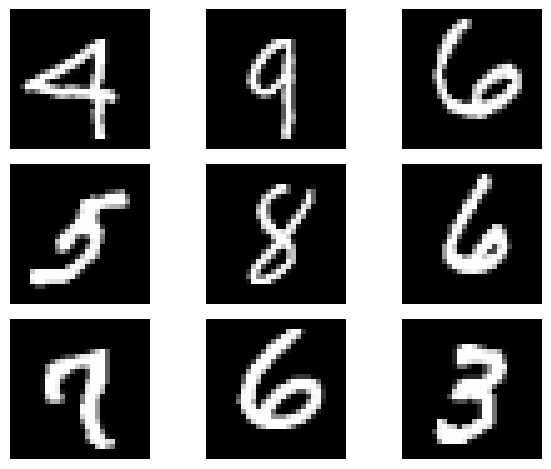

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=3)
for i in range(len(axes)):
    for j in range(len(axes[0])):
        idx = np.random.randint(0, len(data))
        image = data[idx]
        axes[i][j].imshow(image, cmap='Greys_r', interpolation='none')
        axes[i][j].set_axis_off()

plt.tight_layout()
plt.show()

## Генератор

In [18]:
class ConvGenerator(nn.Module):
    def __init__(
        self,
        latent_dim: int
    ):
        super().__init__()


        self.layers = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 512, bias=False),
            nn.BatchNorm1d(4 * 4 * 512),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (512, 4, 4)), # 4x4

            nn.Conv2d(512, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=1.75, mode='nearest'), # 7x7

            nn.Conv2d(256, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14x14

            nn.Conv2d(128, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2, mode='nearest'),  # 14x14

            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.layers(x)


In [19]:
latent_dim = 100
generator = ConvGenerator(latent_dim=latent_dim)
generator

ConvGenerator(
  (layers): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Unflatten(dim=1, unflattened_size=(512, 4, 4))
    (4): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Upsample(scale_factor=1.75, mode=nearest)
    (8): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Upsample(scale_factor=2.0, mode=nearest)
    (12): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [20]:
noise = torch.randn((1, latent_dim))

In [21]:
plt.figure(figsize=(8, 2))
plt.imshow(noise[0][None, :], cmap='Greys_r')
plt.axis('off')
plt.show()

In [22]:
noise.shape

torch.Size([1, 100])

In [23]:
generator.eval()
with torch.no_grad():
    gen_data = generator(noise)

In [24]:
gen_data_np = gen_data[0].permute(1, 2, 0).numpy()

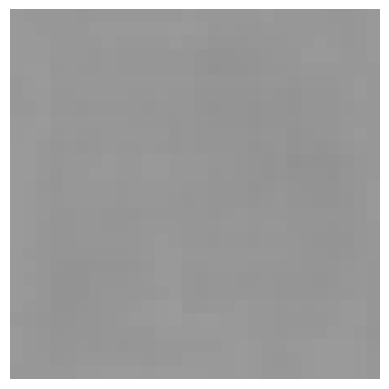

In [25]:
plt.imshow(gen_data_np, vmin=-1.0, vmax=1.0, cmap='Greys_r')
plt.axis('off')
plt.show()

## Дискриминатор

In [26]:
class ConvDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1, stride=2),  # 14x14
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),  # 7x7
            nn.LeakyReLU(0.2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=2),  # 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(start_dim=1, end_dim=-1),
            nn.Linear(256 * 4 * 4, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

In [27]:
discriminator = ConvDiscriminator()
discriminator

ConvDiscriminator(
  (layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=4096, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [28]:
real_data = torch.tensor(data[10], dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

generator.eval()
with torch.no_grad():
    disc_on_gen_data = discriminator(gen_data)
    disc_on_real_data = discriminator(real_data)

real_data_np = real_data[0].permute(1, 2, 0).numpy()

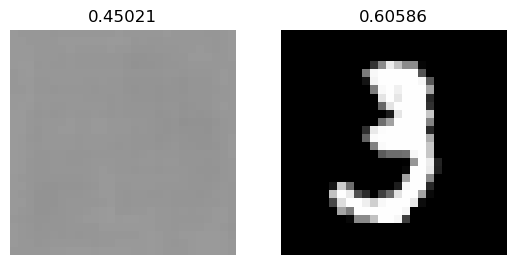

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(gen_data_np, vmin=-1., vmax=1., cmap='Greys_r')
ax1.set_axis_off()
ax1.set_title(f'{disc_on_gen_data.item():.5f}');
ax2.imshow(real_data_np, vmin=-1., vmax=1., cmap='Greys_r')
ax2.set_axis_off()
ax2.set_title(f'{disc_on_real_data.item():.5f}')
plt.subplots_adjust(top=1.15);

## Функции потерь

In [30]:
def compute_generator_loss(generated_data):
    disc_on_generated_data = discriminator(generated_data)

    logp_gen_is_real = torch.clamp(torch.log(disc_on_generated_data), -100, float('inf'))
    loss = -logp_gen_is_real.mean()

    return loss

In [31]:
def compute_discriminator_loss(real_data, generated_data):
    disc_on_real_data = discriminator(real_data)
    disc_on_gen_data = discriminator(generated_data)

    logp_real_is_real = torch.clamp(torch.log(disc_on_real_data), -100, float('inf'))
    logp_gen_is_fake = torch.clamp(torch.log(1 - disc_on_gen_data), -100, float('inf'))

    loss = -(logp_real_is_real + logp_gen_is_fake).mean()
    return loss

## Функции обучения

In [32]:
def sample_data_batch(batch_size):
    idxs = np.random.randint(0, len(data), size=(batch_size,))
    data_batch = torch.tensor(data[idxs]).permute(0, 3, 1, 2)
    if use_cuda:
        data_batch = data_batch.cuda()
    return data_batch

def sample_noise_batch(batch_size):
    noise_batch = torch.randn(batch_size, latent_dim)
    if use_cuda:
        noise_batch = noise_batch.cuda()
    return noise_batch

In [33]:
def make_train_step(batch_size):
    generator.train()
    discriminator.train()

    # Discriminator step
    discriminator.zero_grad()

    noise_batch = sample_noise_batch(batch_size)
    generated_batch = generator(noise_batch)

    data_batch = sample_data_batch(batch_size)

    disc_loss = compute_discriminator_loss(data_batch, generated_batch)

    disc_loss.backward()
    disc_optimizer.step()

    # Generator step
    gen_optimizer.zero_grad()

    noise_batch = sample_noise_batch(batch_size)
    generated_batch = generator(noise_batch)

    gen_loss = compute_generator_loss(generated_batch)

    gen_loss.backward()
    gen_optimizer.step()

    return gen_loss.item(), disc_loss.item()


def train(
    num_steps: int,
    batch_size: int,
    save_results_every: int
):

    if use_cuda:
        generator.cuda()
        discriminator.cuda()

    gen_losses = []
    disc_losses = []
    gen_accuracies = []
    disc_accuracies = []

    for step in (pbar := trange(num_steps)):
        gen_loss, disc_loss = make_train_step(batch_size)

        gen_losses.append(gen_loss)
        disc_losses.append(disc_loss)

        pbar.set_description(f'gen_loss={gen_loss:.5f}; disc_loss={disc_loss:.5f}')

        if step % save_results_every == 0:
            make_and_save_results(
                step=step,
                gen_losses=gen_losses,
                disc_losses=disc_losses,
                gen_accuracies=gen_accuracies,
                disc_accuracies=disc_accuracies
            )
            torch.save(
                generator.state_dict(),
                os.path.join(results_dir, 'checkpoints', 'generator.pt')
            )
            torch.save(
                discriminator.state_dict(),
                os.path.join(results_dir, 'checkpoints', 'discriminator.pt')
            )
    make_gif_files()

## Обучение

In [34]:
fixed_noise = sample_noise_batch(batch_size=16)

In [35]:
gen_optimizer = torch.optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [36]:
num_steps = 15001
batch_size = 128
save_results_every = 100

train(num_steps, batch_size, save_results_every);

  0%|          | 0/15001 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

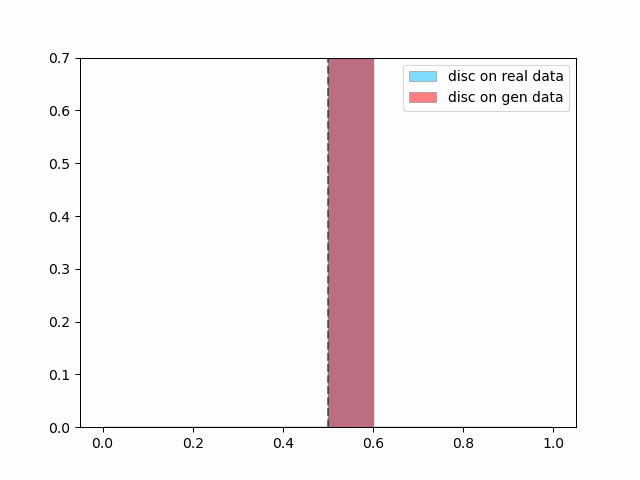

In [27]:
show_gif(hist_plots_gif)

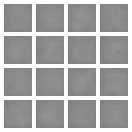

In [28]:
show_gif(fixed_noise_images_gif, size=(448, 448))

## Применение

In [80]:
noise = sample_noise_batch(1)

In [81]:
generator.eval()
with torch.no_grad():
    gen_data = generator(noise)

In [82]:
gen_data_np = gen_data[0].permute(1, 2, 0).cpu().numpy()

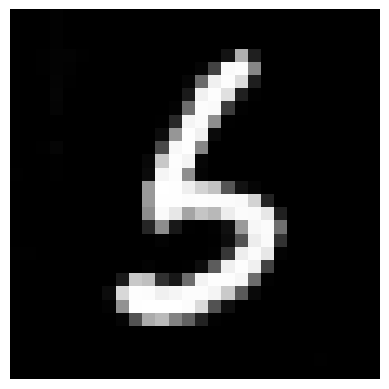

In [83]:
plt.imshow(gen_data_np, vmin=-1.0, vmax=1.0, cmap='Greys_r')
plt.axis('off')
plt.show()

In [57]:
real_data = sample_data_batch(1)

discriminator.eval()
with torch.no_grad():
    disc_on_gen_data = discriminator(gen_data)
    disc_on_real_data = discriminator(real_data)

In [58]:
real_data_np = real_data[0].permute(1, 2, 0).cpu().numpy()

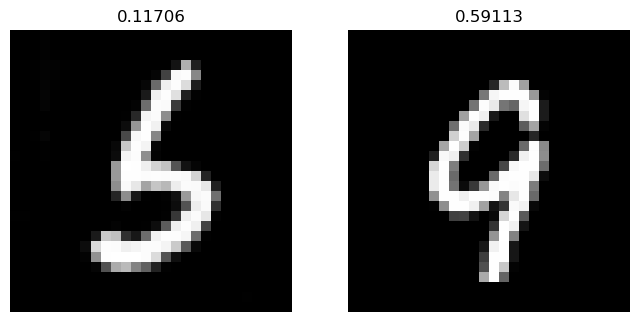

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.imshow(gen_data_np, vmin=-1., vmax=1., cmap='Greys_r')
ax1.set_axis_off()
ax1.set_title(f'{disc_on_gen_data.item():.5f}');
ax2.imshow(real_data_np, vmin=-1., vmax=1., cmap='Greys_r')
ax2.set_axis_off()
ax2.set_title(f'{disc_on_real_data.item():.5f}')
plt.subplots_adjust(top=1.45);